In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from xgboost import plot_tree, plot_importance
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
data = pd.read_csv('Train_Data.csv')
data.adgroup = pd.Series(data = [int(i[-1]) for i in data.adgroup])
data = data.join(pd.get_dummies(data=data.adgroup, prefix='adgroup'))
data.ad = pd.Series(data = [int(i[-1]) for i in data.ad])
data = data.join(pd.get_dummies(data=data.ad, prefix='ad'))
data['log_impressions'] = np.log2(data['impressions'])
data['log_clicks'] = np.log2(data['clicks']+1)
data['CTR'] = data.clicks/(data.impressions+1)
data['CPC'] = data.cost/(data.clicks+1)
data['CPA'] = data.cost/(data.conversions+1)
data.drop(['date', 'campaign','adgroup', 'ad', 'impressions', 'clicks', 'ad_9'], axis=1, inplace=True)
#data.drop(['date', 'campaign','adgroup', 'ad', 'ad_9'], axis=1, inplace=True)

test = pd.read_csv('Test_Data.csv')
test.adgroup = pd.Series(data = [int(i[-1]) for i in test.adgroup])
test = test.join(pd.get_dummies(data=test.adgroup, prefix='adgroup'))
test.ad = pd.Series(data = [int(i[-1]) for i in test.ad])
test = test.join(pd.get_dummies(data=test.ad, prefix='ad'))
test['log_impressions'] = np.log2(test['impressions'])
test['log_clicks'] = np.log2(test['clicks']+1)
test['CTR'] = test.clicks/(test.impressions+1)
test['CPC'] = test.cost/(test.clicks+1)
test['CPA'] = test.cost/(test.conversions+1)
test.drop(['date', 'campaign','adgroup', 'ad', 'impressions', 'clicks'], axis=1, inplace=True)
#test.drop(['date', 'campaign','adgroup', 'ad'], axis=1, inplace=True)


In [4]:
data.describe()

,cost,conversions,revenue,adgroup_1,adgroup_2,adgroup_3,adgroup_4,ad_0,ad_1,ad_2,...,ad_4,ad_5,ad_6,ad_7,ad_8,log_impressions,log_clicks,CTR,CPC,CPA
count,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,...,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000
mean,2.800834,1.339094,231.865340,0.287464,0.159046,0.365784,0.187705,0.069131,0.139576,0.212645,...,0.062568,0.078320,0.086414,0.118355,0.055349,4.319754,3.473853,0.392228,0.048543,0.773431
std,14.361618,5.223922,1091.742763,0.452629,0.365759,0.481702,0.390519,0.253705,0.346584,0.409223,...,0.242211,0.268704,0.281006,0.323063,0.228685,2.630391,2.362777,0.182432,0.093703,1.810381
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.584963,1.584963,0.312500,0.010000,0.040000
50%,0.210000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,3.000000,0.425101,0.013333,0.170000
75%,1.350000,1.000000,92.600000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.392317,5.285402,0.500000,0.049205,0.678333
max,531.250000,94.000000,20515.410000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,11.661333,10.791163,1.333333,1.905000,28.725000


In [5]:
test.describe()

,cost,conversions,adgroup_1,adgroup_2,adgroup_3,adgroup_4,ad_0,ad_1,ad_2,ad_3,ad_4,ad_5,ad_6,ad_7,ad_8,log_impressions,log_clicks,CTR,CPC,CPA
count,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000
mean,0.381352,0.805031,0.283019,0.198113,0.349057,0.169811,0.040881,0.166667,0.163522,0.179245,0.072327,0.128931,0.110063,0.103774,0.034591,4.203709,3.393144,0.387339,0.009843,0.173566
std,0.591480,1.802480,0.451175,0.399206,0.477423,0.376059,0.198325,0.373265,0.370424,0.384162,0.259437,0.335652,0.313461,0.305447,0.183030,2.614995,2.252508,0.184837,0.004612,0.234395
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.584963,0.307717,0.008785,0.020000
50%,0.105000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.321928,3.321928,0.419104,0.010833,0.090000
75%,0.490000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.686501,5.383626,0.500000,0.012500,0.232083
max,3.530000,15.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.202124,8.113742,1.000000,0.032500,1.680000


In [6]:
#cols = ['impressions', 'clicks', 'cost', 'conversions']
#cols = ['log_impressions', 'log_clicks', 'cost', 'conversions']
cols = ['log_impressions', 'log_clicks', 'cost', 'conversions', 'CTR', 'CPC', 'CPA']
scaler = MinMaxScaler()
data[cols] = scaler.fit_transform(data[cols])
test[cols] = scaler.transform(test[cols])

In [7]:
X = data.drop('revenue', axis=1)
y = data.revenue
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2021)

In [13]:
model = Sequential([Dense(512, activation='relu', input_shape=[X_train.shape[1]]),
                    #Dense(512, activation='relu'),
                    Dense(256, activation='relu'),
                    #Dense(128, activation='relu'),
                    Dense(64, activation='relu'),
                    #Dense(32, activation='relu'),
                    Dense(16, activation='relu'),
                    Dense(1, activation='relu')])

model.compile(optimizer='rmsprop', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test))

Epoch 1/1000
129/129 [==============================] - 1s 3ms/step - loss: 1204896.1250 - root_mean_squared_error: 1097.6776 - val_loss: 497166.3125 - val_root_mean_squared_error: 705.1002
Epoch 2/1000
129/129 [==============================] - 0s 3ms/step - loss: 1000106.1250 - root_mean_squared_error: 1000.0530 - val_loss: 340187.9375 - val_root_mean_squared_error: 583.2563
Epoch 3/1000
129/129 [==============================] - 0s 3ms/step - loss: 658892.0625 - root_mean_squared_error: 811.7217 - val_loss: 139058.3906 - val_root_mean_squared_error: 372.9053
Epoch 4/1000
129/129 [==============================] - 0s 3ms/step - loss: 351545.8438 - root_mean_squared_error: 592.9130 - val_loss: 71938.7969 - val_root_mean_squared_error: 268.2141
Epoch 5/1000
129/129 [==============================] - 0s 3ms/step - loss: 237777.7969 - root_mean_squared_error: 487.6246 - val_loss: 61380.4375 - val_root_mean_squared_error: 247.7508
Epoch 6/1000
129/129 [==============================] - 0s

Epoch 45/1000
129/129 [==============================] - 0s 3ms/step - loss: 78694.3359 - root_mean_squared_error: 280.5251 - val_loss: 54470.1602 - val_root_mean_squared_error: 233.3884
Epoch 46/1000
129/129 [==============================] - 0s 3ms/step - loss: 79806.8828 - root_mean_squared_error: 282.5011 - val_loss: 47774.8867 - val_root_mean_squared_error: 218.5747
Epoch 47/1000
129/129 [==============================] - 0s 3ms/step - loss: 79142.1094 - root_mean_squared_error: 281.3221 - val_loss: 57539.0469 - val_root_mean_squared_error: 239.8730
Epoch 48/1000
129/129 [==============================] - ETA: 0s - loss: 78348.4531 - root_mean_squared_error: 279.907 - 0s 3ms/step - loss: 78436.9844 - root_mean_squared_error: 280.0660 - val_loss: 65935.1641 - val_root_mean_squared_error: 256.7784
Epoch 49/1000
129/129 [==============================] - 0s 3ms/step - loss: 78983.9766 - root_mean_squared_error: 281.0409 - val_loss: 43410.8906 - val_root_mean_squared_error: 208.3528
E

129/129 [==============================] - 0s 3ms/step - loss: 51218.9023 - root_mean_squared_error: 226.3159 - val_loss: 30498.0547 - val_root_mean_squared_error: 174.6369
Epoch 89/1000
129/129 [==============================] - 0s 3ms/step - loss: 54922.5977 - root_mean_squared_error: 234.3557 - val_loss: 28023.7969 - val_root_mean_squared_error: 167.4031
Epoch 90/1000
129/129 [==============================] - 0s 3ms/step - loss: 52705.5000 - root_mean_squared_error: 229.5768 - val_loss: 24245.6816 - val_root_mean_squared_error: 155.7103
Epoch 91/1000
129/129 [==============================] - 0s 3ms/step - loss: 51467.3672 - root_mean_squared_error: 226.8642 - val_loss: 25331.8125 - val_root_mean_squared_error: 159.1597
Epoch 92/1000
129/129 [==============================] - 0s 3ms/step - loss: 58468.9844 - root_mean_squared_error: 241.8036 - val_loss: 23343.6484 - val_root_mean_squared_error: 152.7863
Epoch 93/1000
129/129 [==============================] - 0s 3ms/step - loss: 51

Epoch 132/1000
129/129 [==============================] - 0s 3ms/step - loss: 43002.7344 - root_mean_squared_error: 207.3710 - val_loss: 29661.2344 - val_root_mean_squared_error: 172.2244
Epoch 133/1000
129/129 [==============================] - 0s 3ms/step - loss: 41795.0625 - root_mean_squared_error: 204.4384 - val_loss: 28369.3574 - val_root_mean_squared_error: 168.4321
Epoch 134/1000
129/129 [==============================] - 0s 3ms/step - loss: 39460.2344 - root_mean_squared_error: 198.6460 - val_loss: 29058.4336 - val_root_mean_squared_error: 170.4653
Epoch 135/1000
129/129 [==============================] - 0s 3ms/step - loss: 40877.7266 - root_mean_squared_error: 202.1824 - val_loss: 31417.5625 - val_root_mean_squared_error: 177.2500
Epoch 136/1000
129/129 [==============================] - 0s 3ms/step - loss: 42384.0742 - root_mean_squared_error: 205.8739 - val_loss: 24154.4688 - val_root_mean_squared_error: 155.4171
Epoch 137/1000
129/129 [==============================] - 0s

129/129 [==============================] - 0s 3ms/step - loss: 36671.3359 - root_mean_squared_error: 191.4976 - val_loss: 35338.7461 - val_root_mean_squared_error: 187.9860
Epoch 176/1000
129/129 [==============================] - 0s 2ms/step - loss: 34736.4805 - root_mean_squared_error: 186.3773 - val_loss: 24603.3965 - val_root_mean_squared_error: 156.8547
Epoch 177/1000
129/129 [==============================] - 0s 2ms/step - loss: 35411.9023 - root_mean_squared_error: 188.1805 - val_loss: 28090.5000 - val_root_mean_squared_error: 167.6022
Epoch 178/1000
129/129 [==============================] - 0s 2ms/step - loss: 36166.4102 - root_mean_squared_error: 190.1747 - val_loss: 41099.3750 - val_root_mean_squared_error: 202.7298
Epoch 179/1000
129/129 [==============================] - 0s 2ms/step - loss: 34829.5625 - root_mean_squared_error: 186.6268 - val_loss: 35651.6602 - val_root_mean_squared_error: 188.8165
Epoch 180/1000
129/129 [==============================] - 0s 3ms/step - los

129/129 [==============================] - 0s 3ms/step - loss: 29777.5215 - root_mean_squared_error: 172.5616 - val_loss: 48411.8438 - val_root_mean_squared_error: 220.0269
Epoch 219/1000
129/129 [==============================] - 0s 3ms/step - loss: 30158.8359 - root_mean_squared_error: 173.6630 - val_loss: 35776.7773 - val_root_mean_squared_error: 189.1475
Epoch 220/1000
129/129 [==============================] - 0s 2ms/step - loss: 30985.1758 - root_mean_squared_error: 176.0261 - val_loss: 30453.5742 - val_root_mean_squared_error: 174.5095
Epoch 221/1000
129/129 [==============================] - 0s 2ms/step - loss: 31994.4805 - root_mean_squared_error: 178.8700 - val_loss: 39521.8789 - val_root_mean_squared_error: 198.8011
Epoch 222/1000
129/129 [==============================] - 0s 2ms/step - loss: 31179.2012 - root_mean_squared_error: 176.5763 - val_loss: 26111.1270 - val_root_mean_squared_error: 161.5894
Epoch 223/1000
129/129 [==============================] - 0s 2ms/step - los

Epoch 262/1000
129/129 [==============================] - 0s 2ms/step - loss: 29473.1152 - root_mean_squared_error: 171.6774 - val_loss: 35204.7148 - val_root_mean_squared_error: 187.6292
Epoch 263/1000
129/129 [==============================] - 0s 3ms/step - loss: 28437.4941 - root_mean_squared_error: 168.6342 - val_loss: 25592.7207 - val_root_mean_squared_error: 159.9772
Epoch 264/1000
129/129 [==============================] - 0s 3ms/step - loss: 28421.0898 - root_mean_squared_error: 168.5856 - val_loss: 41544.0156 - val_root_mean_squared_error: 203.8235
Epoch 265/1000
129/129 [==============================] - 0s 2ms/step - loss: 26797.9277 - root_mean_squared_error: 163.7007 - val_loss: 42502.5234 - val_root_mean_squared_error: 206.1614
Epoch 266/1000
129/129 [==============================] - 0s 3ms/step - loss: 28535.1543 - root_mean_squared_error: 168.9235 - val_loss: 34228.7148 - val_root_mean_squared_error: 185.0100
Epoch 267/1000
129/129 [==============================] - 0s

129/129 [==============================] - 0s 2ms/step - loss: 25826.9609 - root_mean_squared_error: 160.7077 - val_loss: 30947.2012 - val_root_mean_squared_error: 175.9182
Epoch 306/1000
129/129 [==============================] - 0s 2ms/step - loss: 25549.9258 - root_mean_squared_error: 159.8434 - val_loss: 28575.2246 - val_root_mean_squared_error: 169.0421
Epoch 307/1000
129/129 [==============================] - 0s 3ms/step - loss: 26530.2031 - root_mean_squared_error: 162.8810 - val_loss: 38604.0234 - val_root_mean_squared_error: 196.4791
Epoch 308/1000
129/129 [==============================] - 0s 3ms/step - loss: 25335.7031 - root_mean_squared_error: 159.1719 - val_loss: 50844.5898 - val_root_mean_squared_error: 225.4874
Epoch 309/1000
129/129 [==============================] - 0s 2ms/step - loss: 26139.8672 - root_mean_squared_error: 161.6783 - val_loss: 32699.1895 - val_root_mean_squared_error: 180.8292
Epoch 310/1000
129/129 [==============================] - 0s 2ms/step - los

Epoch 349/1000
129/129 [==============================] - 0s 3ms/step - loss: 23183.5840 - root_mean_squared_error: 152.2616 - val_loss: 27405.7480 - val_root_mean_squared_error: 165.5468
Epoch 350/1000
129/129 [==============================] - 0s 3ms/step - loss: 24677.5762 - root_mean_squared_error: 157.0910 - val_loss: 43021.2383 - val_root_mean_squared_error: 207.4156
Epoch 351/1000
129/129 [==============================] - 0s 3ms/step - loss: 23256.1367 - root_mean_squared_error: 152.4996 - val_loss: 35528.0742 - val_root_mean_squared_error: 188.4889
Epoch 352/1000
129/129 [==============================] - 0s 2ms/step - loss: 24616.1484 - root_mean_squared_error: 156.8953 - val_loss: 29894.7891 - val_root_mean_squared_error: 172.9011
Epoch 353/1000
129/129 [==============================] - 0s 3ms/step - loss: 24658.5723 - root_mean_squared_error: 157.0305 - val_loss: 34433.2695 - val_root_mean_squared_error: 185.5620
Epoch 354/1000
129/129 [==============================] - 0s

129/129 [==============================] - 0s 3ms/step - loss: 23761.1914 - root_mean_squared_error: 154.1467 - val_loss: 31501.1895 - val_root_mean_squared_error: 177.4857
Epoch 393/1000
129/129 [==============================] - 0s 3ms/step - loss: 22848.2656 - root_mean_squared_error: 151.1564 - val_loss: 32151.4805 - val_root_mean_squared_error: 179.3083
Epoch 394/1000
129/129 [==============================] - 0s 3ms/step - loss: 24308.2168 - root_mean_squared_error: 155.9109 - val_loss: 31081.6895 - val_root_mean_squared_error: 176.3000
Epoch 395/1000
129/129 [==============================] - 0s 3ms/step - loss: 22022.7793 - root_mean_squared_error: 148.4007 - val_loss: 25400.3340 - val_root_mean_squared_error: 159.3748
Epoch 396/1000
129/129 [==============================] - 0s 2ms/step - loss: 21681.8223 - root_mean_squared_error: 147.2475 - val_loss: 32881.3711 - val_root_mean_squared_error: 181.3322
Epoch 397/1000
129/129 [==============================] - 0s 2ms/step - los

Epoch 436/1000
129/129 [==============================] - 0s 2ms/step - loss: 21944.8945 - root_mean_squared_error: 148.1381 - val_loss: 42766.6758 - val_root_mean_squared_error: 206.8011
Epoch 437/1000
129/129 [==============================] - 0s 2ms/step - loss: 21793.2930 - root_mean_squared_error: 147.6255 - val_loss: 30367.9941 - val_root_mean_squared_error: 174.2641
Epoch 438/1000
129/129 [==============================] - 0s 2ms/step - loss: 22025.0801 - root_mean_squared_error: 148.4085 - val_loss: 25007.4961 - val_root_mean_squared_error: 158.1376
Epoch 439/1000
129/129 [==============================] - 0s 2ms/step - loss: 20817.7969 - root_mean_squared_error: 144.2837 - val_loss: 34718.5625 - val_root_mean_squared_error: 186.3292
Epoch 440/1000
129/129 [==============================] - 0s 3ms/step - loss: 20109.9648 - root_mean_squared_error: 141.8096 - val_loss: 43458.4805 - val_root_mean_squared_error: 208.4670
Epoch 441/1000
129/129 [==============================] - 0s

129/129 [==============================] - 0s 3ms/step - loss: 21399.7305 - root_mean_squared_error: 146.2865 - val_loss: 30526.7754 - val_root_mean_squared_error: 174.7191
Epoch 480/1000
129/129 [==============================] - 0s 3ms/step - loss: 19759.7910 - root_mean_squared_error: 140.5695 - val_loss: 36632.0078 - val_root_mean_squared_error: 191.3949
Epoch 481/1000
129/129 [==============================] - 0s 3ms/step - loss: 21016.1387 - root_mean_squared_error: 144.9694 - val_loss: 64984.2930 - val_root_mean_squared_error: 254.9202
Epoch 482/1000
129/129 [==============================] - 0s 2ms/step - loss: 20205.2285 - root_mean_squared_error: 142.1451 - val_loss: 31972.7930 - val_root_mean_squared_error: 178.8094
Epoch 483/1000
129/129 [==============================] - 0s 2ms/step - loss: 20545.9141 - root_mean_squared_error: 143.3385 - val_loss: 32243.8320 - val_root_mean_squared_error: 179.5657
Epoch 484/1000
129/129 [==============================] - 0s 2ms/step - los

Epoch 523/1000
129/129 [==============================] - 0s 3ms/step - loss: 21920.6074 - root_mean_squared_error: 148.0561 - val_loss: 40736.5938 - val_root_mean_squared_error: 201.8331
Epoch 524/1000
129/129 [==============================] - 0s 3ms/step - loss: 20093.2305 - root_mean_squared_error: 141.7506 - val_loss: 46040.1953 - val_root_mean_squared_error: 214.5698
Epoch 525/1000
129/129 [==============================] - 0s 3ms/step - loss: 20749.1836 - root_mean_squared_error: 144.0458 - val_loss: 42026.3672 - val_root_mean_squared_error: 205.0033
Epoch 526/1000
129/129 [==============================] - 0s 3ms/step - loss: 20135.2148 - root_mean_squared_error: 141.8986 - val_loss: 31975.3496 - val_root_mean_squared_error: 178.8165
Epoch 527/1000
129/129 [==============================] - 0s 3ms/step - loss: 19393.9512 - root_mean_squared_error: 139.2622 - val_loss: 71967.4609 - val_root_mean_squared_error: 268.2675
Epoch 528/1000
129/129 [==============================] - 0s

129/129 [==============================] - 0s 3ms/step - loss: 18958.6016 - root_mean_squared_error: 137.6902 - val_loss: 39982.2891 - val_root_mean_squared_error: 199.9557
Epoch 567/1000
129/129 [==============================] - 0s 3ms/step - loss: 17622.8965 - root_mean_squared_error: 132.7513 - val_loss: 41569.0273 - val_root_mean_squared_error: 203.8848
Epoch 568/1000
129/129 [==============================] - 0s 3ms/step - loss: 21529.5801 - root_mean_squared_error: 146.7296 - val_loss: 35176.0898 - val_root_mean_squared_error: 187.5529
Epoch 569/1000
129/129 [==============================] - 0s 3ms/step - loss: 18952.1367 - root_mean_squared_error: 137.6668 - val_loss: 40527.3984 - val_root_mean_squared_error: 201.3142
Epoch 570/1000
129/129 [==============================] - 0s 3ms/step - loss: 18392.5137 - root_mean_squared_error: 135.6190 - val_loss: 50598.1758 - val_root_mean_squared_error: 224.9404
Epoch 571/1000
129/129 [==============================] - 0s 3ms/step - los

Epoch 610/1000
129/129 [==============================] - 0s 3ms/step - loss: 18272.3398 - root_mean_squared_error: 135.1752 - val_loss: 43700.5273 - val_root_mean_squared_error: 209.0467
Epoch 611/1000
129/129 [==============================] - 0s 3ms/step - loss: 17409.9355 - root_mean_squared_error: 131.9467 - val_loss: 41666.6289 - val_root_mean_squared_error: 204.1241
Epoch 612/1000
129/129 [==============================] - 0s 3ms/step - loss: 19836.6855 - root_mean_squared_error: 140.8428 - val_loss: 35389.3438 - val_root_mean_squared_error: 188.1206
Epoch 613/1000
129/129 [==============================] - 0s 3ms/step - loss: 18412.9336 - root_mean_squared_error: 135.6943 - val_loss: 50787.1758 - val_root_mean_squared_error: 225.3601
Epoch 614/1000
129/129 [==============================] - 0s 3ms/step - loss: 17524.3516 - root_mean_squared_error: 132.3796 - val_loss: 41951.0859 - val_root_mean_squared_error: 204.8196
Epoch 615/1000
129/129 [==============================] - 0s

129/129 [==============================] - 0s 2ms/step - loss: 18014.3320 - root_mean_squared_error: 134.2175 - val_loss: 43422.2109 - val_root_mean_squared_error: 208.3800
Epoch 654/1000
129/129 [==============================] - 0s 3ms/step - loss: 16617.3594 - root_mean_squared_error: 128.9083 - val_loss: 47425.4219 - val_root_mean_squared_error: 217.7738
Epoch 655/1000
129/129 [==============================] - 0s 3ms/step - loss: 17377.9824 - root_mean_squared_error: 131.8256 - val_loss: 55968.5508 - val_root_mean_squared_error: 236.5767
Epoch 656/1000
129/129 [==============================] - 0s 3ms/step - loss: 17296.9473 - root_mean_squared_error: 131.5179 - val_loss: 34349.4023 - val_root_mean_squared_error: 185.3359
Epoch 657/1000
129/129 [==============================] - 0s 3ms/step - loss: 17349.0918 - root_mean_squared_error: 131.7160 - val_loss: 58296.7617 - val_root_mean_squared_error: 241.4472
Epoch 658/1000
129/129 [==============================] - 0s 3ms/step - los

Epoch 697/1000
129/129 [==============================] - 0s 3ms/step - loss: 15821.1318 - root_mean_squared_error: 125.7821 - val_loss: 45206.8789 - val_root_mean_squared_error: 212.6191
Epoch 698/1000
129/129 [==============================] - 0s 3ms/step - loss: 17185.3086 - root_mean_squared_error: 131.0927 - val_loss: 38124.1484 - val_root_mean_squared_error: 195.2541
Epoch 699/1000
129/129 [==============================] - 0s 3ms/step - loss: 16969.7812 - root_mean_squared_error: 130.2681 - val_loss: 43961.5859 - val_root_mean_squared_error: 209.6702
Epoch 700/1000
129/129 [==============================] - 0s 3ms/step - loss: 16867.5352 - root_mean_squared_error: 129.8751 - val_loss: 44695.2539 - val_root_mean_squared_error: 211.4125
Epoch 701/1000
129/129 [==============================] - 0s 3ms/step - loss: 16968.0566 - root_mean_squared_error: 130.2615 - val_loss: 43343.4141 - val_root_mean_squared_error: 208.1908
Epoch 702/1000
129/129 [==============================] - 0s

129/129 [==============================] - 0s 3ms/step - loss: 15762.2969 - root_mean_squared_error: 125.5480 - val_loss: 37699.9883 - val_root_mean_squared_error: 194.1648
Epoch 741/1000
129/129 [==============================] - 0s 2ms/step - loss: 16705.2305 - root_mean_squared_error: 129.2487 - val_loss: 46792.8203 - val_root_mean_squared_error: 216.3165
Epoch 742/1000
129/129 [==============================] - 0s 3ms/step - loss: 15273.4170 - root_mean_squared_error: 123.5857 - val_loss: 38173.4492 - val_root_mean_squared_error: 195.3803
Epoch 743/1000
129/129 [==============================] - 0s 3ms/step - loss: 16678.4180 - root_mean_squared_error: 129.1449 - val_loss: 39204.2539 - val_root_mean_squared_error: 198.0006
Epoch 744/1000
129/129 [==============================] - 0s 3ms/step - loss: 16128.0742 - root_mean_squared_error: 126.9964 - val_loss: 35035.6641 - val_root_mean_squared_error: 187.1782
Epoch 745/1000
129/129 [==============================] - 0s 3ms/step - los

Epoch 784/1000
129/129 [==============================] - 0s 2ms/step - loss: 16530.9766 - root_mean_squared_error: 128.5728 - val_loss: 41911.3281 - val_root_mean_squared_error: 204.7226
Epoch 785/1000
129/129 [==============================] - 0s 3ms/step - loss: 16130.2852 - root_mean_squared_error: 127.0051 - val_loss: 35649.3477 - val_root_mean_squared_error: 188.8103
Epoch 786/1000
129/129 [==============================] - 0s 3ms/step - loss: 15333.9258 - root_mean_squared_error: 123.8302 - val_loss: 33861.9180 - val_root_mean_squared_error: 184.0161
Epoch 787/1000
129/129 [==============================] - 0s 3ms/step - loss: 16326.0430 - root_mean_squared_error: 127.7734 - val_loss: 36639.7617 - val_root_mean_squared_error: 191.4152
Epoch 788/1000
129/129 [==============================] - 0s 3ms/step - loss: 15749.7402 - root_mean_squared_error: 125.4980 - val_loss: 39683.1914 - val_root_mean_squared_error: 199.2064
Epoch 789/1000
129/129 [==============================] - 0s

129/129 [==============================] - 0s 3ms/step - loss: 16159.3906 - root_mean_squared_error: 127.1196 - val_loss: 43578.0000 - val_root_mean_squared_error: 208.7534
Epoch 828/1000
129/129 [==============================] - 0s 3ms/step - loss: 15140.4893 - root_mean_squared_error: 123.0467 - val_loss: 33814.2812 - val_root_mean_squared_error: 183.8866
Epoch 829/1000
129/129 [==============================] - 0s 2ms/step - loss: 15672.5273 - root_mean_squared_error: 125.1900 - val_loss: 40902.8164 - val_root_mean_squared_error: 202.2444
Epoch 830/1000
129/129 [==============================] - 0s 2ms/step - loss: 16693.8750 - root_mean_squared_error: 129.2048 - val_loss: 39781.4102 - val_root_mean_squared_error: 199.4528
Epoch 831/1000
129/129 [==============================] - 0s 3ms/step - loss: 15704.0391 - root_mean_squared_error: 125.3158 - val_loss: 49016.1992 - val_root_mean_squared_error: 221.3960
Epoch 832/1000
129/129 [==============================] - 0s 3ms/step - los

Epoch 871/1000
129/129 [==============================] - 0s 2ms/step - loss: 16396.8047 - root_mean_squared_error: 128.0500 - val_loss: 34088.9922 - val_root_mean_squared_error: 184.6320
Epoch 872/1000
129/129 [==============================] - 0s 3ms/step - loss: 15524.9688 - root_mean_squared_error: 124.5992 - val_loss: 46031.1406 - val_root_mean_squared_error: 214.5487
Epoch 873/1000
129/129 [==============================] - 0s 3ms/step - loss: 15185.7373 - root_mean_squared_error: 123.2304 - val_loss: 41851.1602 - val_root_mean_squared_error: 204.5756
Epoch 874/1000
129/129 [==============================] - 0s 3ms/step - loss: 15115.5566 - root_mean_squared_error: 122.9453 - val_loss: 39314.9297 - val_root_mean_squared_error: 198.2799
Epoch 875/1000
129/129 [==============================] - 0s 3ms/step - loss: 15565.8877 - root_mean_squared_error: 124.7633 - val_loss: 52143.1719 - val_root_mean_squared_error: 228.3488
Epoch 876/1000
129/129 [==============================] - 0s

129/129 [==============================] - 0s 2ms/step - loss: 14014.2354 - root_mean_squared_error: 118.3817 - val_loss: 47200.5391 - val_root_mean_squared_error: 217.2569
Epoch 915/1000
129/129 [==============================] - 0s 3ms/step - loss: 16056.8818 - root_mean_squared_error: 126.7158 - val_loss: 36782.5938 - val_root_mean_squared_error: 191.7879
Epoch 916/1000
129/129 [==============================] - 0s 3ms/step - loss: 15553.9434 - root_mean_squared_error: 124.7154 - val_loss: 43697.7305 - val_root_mean_squared_error: 209.0400
Epoch 917/1000
129/129 [==============================] - 0s 3ms/step - loss: 15141.2949 - root_mean_squared_error: 123.0500 - val_loss: 43792.5391 - val_root_mean_squared_error: 209.2667
Epoch 918/1000
129/129 [==============================] - 0s 3ms/step - loss: 15478.5811 - root_mean_squared_error: 124.4129 - val_loss: 39327.9141 - val_root_mean_squared_error: 198.3127
Epoch 919/1000
129/129 [==============================] - 0s 3ms/step - los

Epoch 958/1000
129/129 [==============================] - 0s 2ms/step - loss: 14447.9111 - root_mean_squared_error: 120.1995 - val_loss: 43841.9609 - val_root_mean_squared_error: 209.3847
Epoch 959/1000
129/129 [==============================] - 0s 2ms/step - loss: 14402.4971 - root_mean_squared_error: 120.0104 - val_loss: 42795.4688 - val_root_mean_squared_error: 206.8707
Epoch 960/1000
129/129 [==============================] - 0s 3ms/step - loss: 14815.1934 - root_mean_squared_error: 121.7177 - val_loss: 52090.8906 - val_root_mean_squared_error: 228.2343
Epoch 961/1000
129/129 [==============================] - 0s 3ms/step - loss: 15353.9863 - root_mean_squared_error: 123.9112 - val_loss: 58975.4180 - val_root_mean_squared_error: 242.8486
Epoch 962/1000
129/129 [==============================] - 0s 3ms/step - loss: 14029.4229 - root_mean_squared_error: 118.4459 - val_loss: 39911.4766 - val_root_mean_squared_error: 199.7786
Epoch 963/1000
129/129 [==============================] - 0s

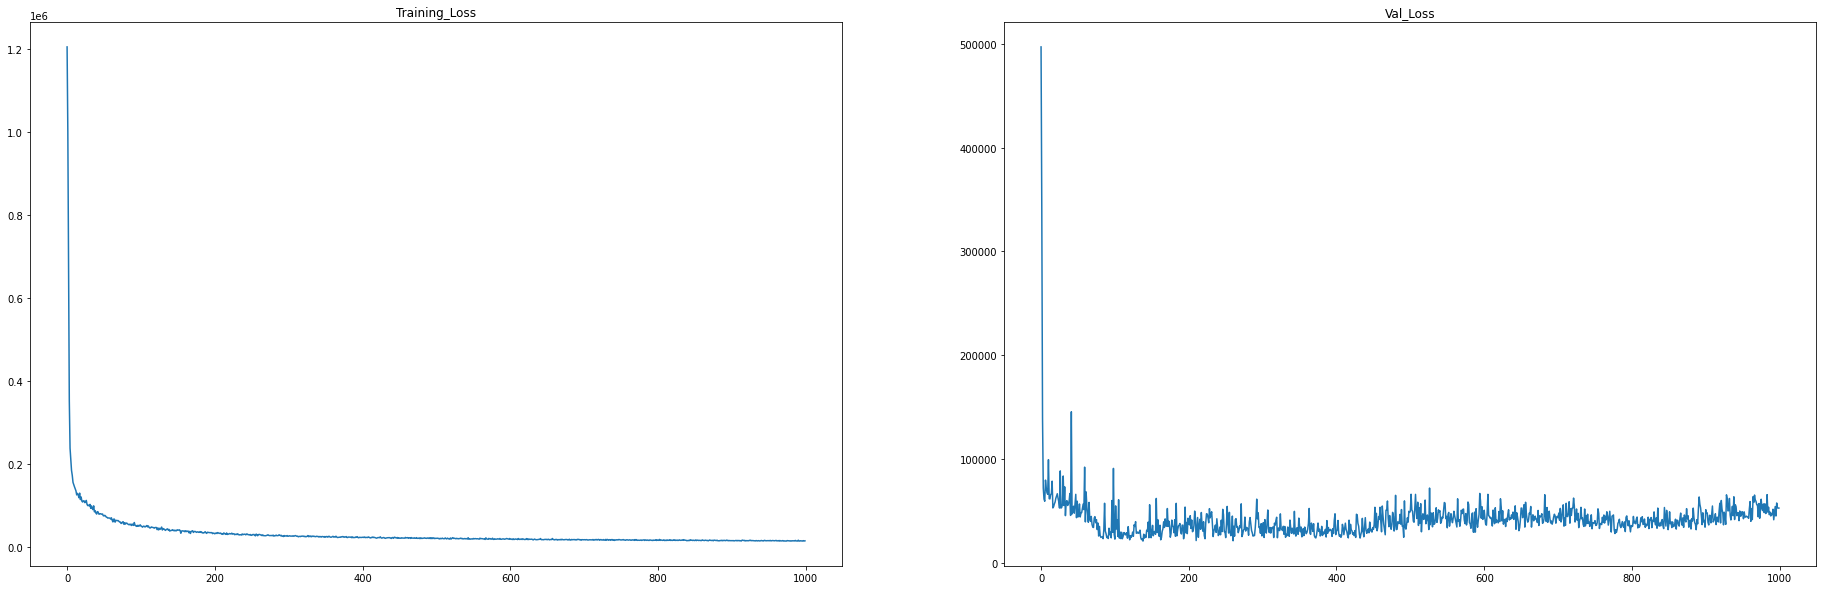

In [14]:
plt.figure(figsize=(32,10))
plt.subplot(121)
plt.title('Training_Loss')
plt.plot(history.history['loss'])
plt.subplot(122)
plt.title('Val_Loss')
plt.plot(history.history['val_loss'])
plt.show()

In [15]:
pred = model.predict(test)

In [16]:
result = pd.read_csv('Sample_Submission.csv')
result.revenue = pred
result.to_csv('Resultnew.csv')